# Model Output Data Visualization

### Read Me

This notebook vizualizes model outputs for supervised neural methods from the rPPG Toolbox. To use this notebook follow the following steps:

* STEP 1: Specify the `TEST.OUTPUT_SAVE_DIR` field in the `.yaml` config file of a neural method experiment.
* STEP 2: Run the neural method experiment. A `.pickle` file containing the test-data predictions and labels will be created in `TEST.OUTPUT_SAVE_DIR`.
* STEP 3: Add the path to the `pickle` file in the `TODO: Variable to Set` section as `data_out_path`.
* STEP 4: Add values for `trial_idx` (a value between 0 and the `Num Trials` print in the previous cell), `chunk_size` (number of samples to plot out), `chunk_num` (the chunk of size `chunk_size` in the signal). We suggest using the defaults at first.
* STEP 5: Run all cells. The predicted output, plotted against the ground truth ppg waveform, will be plotted in the final cell

### Imports

In [92]:
# !pip install natsort opencv-python 
# !pip install scipy
# !pip install natsort
# !pip install ipywidgets

import pathlib as pathlib
import cv2
import pickle
import numpy as np
import os
import matplotlib.pyplot as plt
import re

import torch

import numpy as np
# import ipywidgets as widgets
from IPython.display import display, clear_output
from natsort import natsorted
import os
import scipy
from scipy.sparse import spdiags
from scipy.signal import butter
import math
from scipy import linalg
from scipy import signal
from scipy import sparse

def find_git_root(path=None):
    """Find the root of the git repository by searching for .git."""
    if path is None:
        path = pathlib.Path.cwd()
    for parent in [path] + list(path.parents):
        if (parent / ".git").exists():
            return parent
    raise FileNotFoundError("No .git directory found in any parent directories.")
# "\\wsl.localhost\Ubuntu-22.04\home\maciek\GitHub\rPPG-Toolbox\model_outputs\PURE_PURE_UBFC_deepphys_outputs.pickle"
# Usage:

repo_root = find_git_root()
# data_out_path = repo_root / "model_outputs/PURE_PURE_UBFC_deepphys_outputs.pickle"
data_out_path = repo_root / "runs/my_avi_tscan_inference_cpu/my_avi_tscan_preprocessed/saved_test_outputs/PURE_TSCAN_UBFC-rPPG_outputs.pickle"

### Helper Functions

In [20]:
# HELPER FUNCTIONS

def _reform_data_from_dict(data, flatten=True):
    """Helper func for calculate metrics: reformat predictions and labels from dicts. """
    sort_data = sorted(data.items(), key=lambda x: x[0])
    sort_data = [i[1] for i in sort_data]
    sort_data = torch.cat(sort_data, dim=0)

    if flatten:
        sort_data = np.reshape(sort_data.cpu(), (-1))
    else:
        sort_data = np.array(sort_data.cpu())

    return sort_data

def _process_signal(signal, fs=30, diff_flag=True):
    # Detrend and filter
    use_bandpass = True
    if diff_flag:  # if the predictions and labels are 1st derivative of PPG signal.
        gt_bvp = _detrend(np.cumsum(signal), 100)
    else:
        gt_bvp = _detrend(signal, 100)
    if use_bandpass:
        # bandpass filter between [0.75, 2.5] Hz
        # equals [45, 150] beats per min
        [b, a] = butter(1, [0.75 / fs * 2, 2.5 / fs * 2], btype='bandpass')
        signal = scipy.signal.filtfilt(b, a, np.double(signal))
    return signal

def _detrend(input_signal, lambda_value):
    """Detrend PPG signal."""
    signal_length = input_signal.shape[0]
    # observation matrix
    H = np.identity(signal_length)
    ones = np.ones(signal_length)
    minus_twos = -2 * np.ones(signal_length)
    diags_data = np.array([ones, minus_twos, ones])
    diags_index = np.array([0, 1, 2])
    D = spdiags(diags_data, diags_index,
                (signal_length - 2), signal_length).toarray()
    detrended_signal = np.dot(
        (H - np.linalg.inv(H + (lambda_value ** 2) * np.dot(D.T, D))), input_signal)
    return detrended_signal


### TODO: Variables To Set

In [79]:
# data_out_path = "./sample_output.pickle"  # Output Data Path NOT NEEDED ANYMORE
trial_idx = 0
chunk_size = 180 # size of chunk to visualize: -1 will plot the entire signal
chunk_num = 0

### Read Data, and Extract Trials List

In [ ]:
if not data_out_path.exists():
    print(f"ERROR: File not found: {data_out_path}")
else:
    with open(data_out_path, 'rb') as f:
        data = pickle.load(f)
        
    # List of all video trials
    trial_list = list(data['predictions'].keys())
    print('Num Trials', len(trial_list))

Num Trials 1


In [ ]:
# data.keys()  # ['predictions', 'labels', 'video_fps', 'video_names']
# data['predictions'].keys()  # ['PURE_TSCAN_UBFC_1', 'PURE_TSCAN_UBFC_2', ...]

dict_keys(['subject1'])

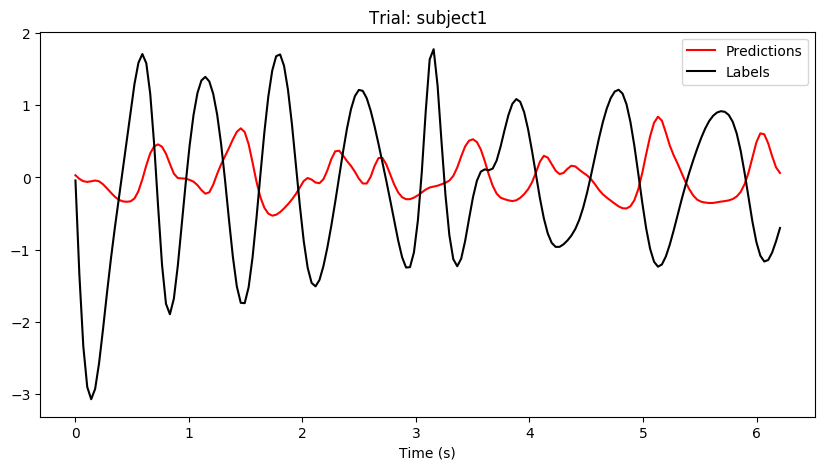

In [81]:
# Reform label and prediction vectors from multiple trial chunks
prediction = np.array(_reform_data_from_dict(data['predictions'][trial_list[trial_idx]]))
label = np.array(_reform_data_from_dict(data['labels'][trial_list[trial_idx]]))

# Read in meta-data from pickle file
fs = data['fs'] # Video Frame Rate
label_type = data['label_type'] # PPG Signal Transformation: `DiffNormalized` or `Standardized`
diff_flag = (label_type == 'DiffNormalized')

if chunk_size == -1:
    chunk_size = len(prediction)
    chunk_num = 0

# Process label and prediction signals
prediction = _process_signal(prediction, fs, diff_flag=diff_flag)
label = _process_signal(label, fs, diff_flag=diff_flag)
start = (chunk_num)*chunk_size
stop = (chunk_num+1)*chunk_size
samples = stop - start
x_time = np.linspace(0, samples/fs, num=samples)

plt.figure(figsize=(10,5))
plt.plot(x_time, prediction[start:stop], color='r')
plt.plot(x_time, label[start:stop], color='black')
plt.title('Trial: ' + trial_list[trial_idx])
plt.legend(['Predictions', 'Labels'])
plt.xlabel('Time (s)');

In [82]:
import sys
import os
sys.path.append('/home/maciek/GitHub/rPPG-Toolbox')  # Add the toolbox directory

import pickle
import numpy as np
from evaluation.post_process import calculate_metric_per_video

# Load your results
with open(data_out_path, 'rb') as f:
    results = pickle.load(f)

# Extract predictions from your results
predictions = results['predictions'] if 'predictions' in results else results
labels = results['labels'] if 'labels' in results else None

# Convert PPG signals to heart rate
heart_rates = {}

for subject_id, prediction_chunks in predictions.items():
    # Combine all chunks for this subject
    full_prediction = []
    for chunk_idx in sorted(prediction_chunks.keys()):
        chunk_data = prediction_chunks[chunk_idx]
        if hasattr(chunk_data, 'numpy'):
            chunk_data = chunk_data.numpy()
        full_prediction.extend(chunk_data.flatten())
    
    full_prediction = np.array(full_prediction)
    
    # Convert differential PPG to heart rate using FFT
    # diff_flag=True because your config uses DiffNormalized
    hr_label, hr_pred, SNR, macc = calculate_metric_per_video(
        full_prediction, 
        full_prediction,  # Using prediction as both pred and label for now
        fs=30,  # Your sampling frequency
        diff_flag=True,  # Because you're using DiffNormalized
        use_bandpass=True,
        hr_method='FFT'
    )
    
    heart_rates[subject_id] = hr_pred

print("Heart rates (BPM) for each subject:")
for subject_id, hr in heart_rates.items():
    print(f"Subject {subject_id}: {hr:.1f} BPM")

Heart rates (BPM) for each subject:
Subject subject1: 65.9 BPM


In [83]:
with open(data_out_path, 'rb') as f:
    results = pickle.load(f)

print("=== PICKLE FILE ANALYSIS ===")
print("Type:", type(results))
print("Keys:", list(results.keys()) if isinstance(results, dict) else "Not a dict")

# If it's the standard format with predictions and labels
if 'predictions' in results:
    predictions = results['predictions']
    labels = results['labels']
    
    print(f"\nNumber of subjects in predictions: {len(predictions)}")
    print(f"Number of subjects in labels: {len(labels)}")
    
    print("\nSubjects in predictions:")
    for subject_id in predictions.keys():
        chunks = len(predictions[subject_id])
        print(f"  {subject_id}: {chunks} chunks")
    
    # Check if subject1 exists (your current run)
    if 'subject1' in predictions:
        print(f"\n=== SUBJECT1 DETAILS (Your Current Run) ===")
        subject1_chunks = predictions['subject1']
        print(f"Number of chunks: {len(subject1_chunks)}")
        print(f"Chunk indices: {sorted(subject1_chunks.keys())}")
        
        # Show data shape for first chunk
        first_chunk = subject1_chunks[sorted(subject1_chunks.keys())[0]]
        print(f"First chunk shape: {first_chunk.shape if hasattr(first_chunk, 'shape') else len(first_chunk)}")
        
else:
    print("Unexpected pickle file structure")
    print("Contents:", results)

=== PICKLE FILE ANALYSIS ===
Type: <class 'dict'>
Keys: ['predictions', 'labels', 'label_type', 'fs']

Number of subjects in predictions: 1
Number of subjects in labels: 1

Subjects in predictions:
  subject1: 11 chunks

=== SUBJECT1 DETAILS (Your Current Run) ===
Number of chunks: 11
Chunk indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
First chunk shape: torch.Size([180, 1])


In [84]:
import pickle
import numpy as np
import scipy.signal
from scipy.signal import butter

def convert_ppg_to_heart_rate(ppg_signal, fs=30, diff_flag=True):
    """Convert PPG signal to heart rate using FFT"""
    if diff_flag:
        ppg_signal = np.cumsum(ppg_signal)
    
    ppg_signal = scipy.signal.detrend(ppg_signal)
    [b, a] = butter(1, [0.6/fs*2, 3.3/fs*2], btype='bandpass')
    ppg_signal = scipy.signal.filtfilt(b, a, np.double(ppg_signal))
    
    N = 2 ** int(np.ceil(np.log2(len(ppg_signal))))
    f_ppg, pxx_ppg = scipy.signal.periodogram(ppg_signal, fs=fs, nfft=N, detrend=False)
    
    hr_range = (0.6, 3.3)
    valid_indices = np.where((f_ppg >= hr_range[0]) & (f_ppg <= hr_range[1]))[0]
    peak_freq = f_ppg[valid_indices[np.argmax(pxx_ppg[valid_indices])]]
    
    return peak_freq * 60

# Load results
with open(data_out_path, 'rb') as f:
    results = pickle.load(f)

predictions = results['predictions']
fs = results['fs']  # Use the sampling rate from the file

print("=== YOUR VIDEO'S HEART RATE (SUBJECT1) ===")
subject1_data = predictions['subject1']

print(f"Available chunks: {sorted(subject1_data.keys())}")
print(f"Number of chunks: {len(subject1_data)}")

# Combine all chunks for subject1
full_signal = []
total_samples = 0

for chunk_idx in sorted(subject1_data.keys()):
    chunk_data = subject1_data[chunk_idx]
    
    # Convert tensor to numpy if needed
    if hasattr(chunk_data, 'numpy'):
        chunk_data = chunk_data.numpy()
    elif hasattr(chunk_data, 'cpu'):
        chunk_data = chunk_data.cpu().numpy()
    
    chunk_signal = chunk_data.flatten()
    full_signal.extend(chunk_signal)
    total_samples += len(chunk_signal)
    print(f"  Chunk {chunk_idx}: {len(chunk_signal)} samples")

full_signal = np.array(full_signal)

print(f"\nCombined signal:")
print(f"  Total samples: {len(full_signal)}")
print(f"  Duration: {len(full_signal)/fs:.1f} seconds")
print(f"  Sampling rate: {fs} Hz")

# Calculate overall heart rate
hr = convert_ppg_to_heart_rate(full_signal, fs=fs, diff_flag=True)
print(f"\n🫀 YOUR VIDEO'S HEART RATE: {hr:.1f} BPM")

# Calculate per-chunk heart rates for comparison
print(f"\nPer-chunk heart rates:")
chunk_hrs = []
for chunk_idx in sorted(subject1_data.keys()):
    chunk_data = subject1_data[chunk_idx]
    if hasattr(chunk_data, 'numpy'):
        chunk_data = chunk_data.numpy()
    elif hasattr(chunk_data, 'cpu'):
        chunk_data = chunk_data.cpu().numpy()
    
    chunk_signal = chunk_data.flatten()
    if len(chunk_signal) >= 90:  # Need minimum length for reliable FFT (3 seconds)
        chunk_hr = convert_ppg_to_heart_rate(chunk_signal, fs=fs, diff_flag=True)
        chunk_hrs.append(chunk_hr)
        print(f"  Chunk {chunk_idx}: {chunk_hr:.1f} BPM")
    else:
        print(f"  Chunk {chunk_idx}: Too short for reliable HR calculation")

if chunk_hrs:
    print(f"\nHeart rate statistics:")
    print(f"  Mean: {np.mean(chunk_hrs):.1f} BPM")
    print(f"  Std:  {np.std(chunk_hrs):.1f} BPM")
    print(f"  Min:  {np.min(chunk_hrs):.1f} BPM")
    print(f"  Max:  {np.max(chunk_hrs):.1f} BPM")

=== YOUR VIDEO'S HEART RATE (SUBJECT1) ===
Available chunks: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Number of chunks: 11
  Chunk 0: 180 samples
  Chunk 1: 180 samples
  Chunk 2: 180 samples
  Chunk 3: 180 samples
  Chunk 4: 180 samples
  Chunk 5: 180 samples
  Chunk 6: 180 samples
  Chunk 7: 180 samples
  Chunk 8: 180 samples
  Chunk 9: 180 samples
  Chunk 10: 180 samples

Combined signal:
  Total samples: 1980
  Duration: 68.3 seconds
  Sampling rate: 29 Hz

🫀 YOUR VIDEO'S HEART RATE: 63.7 BPM

Per-chunk heart rates:
  Chunk 0: 68.0 BPM
  Chunk 1: 74.8 BPM
  Chunk 2: 61.2 BPM
  Chunk 3: 61.2 BPM
  Chunk 4: 68.0 BPM
  Chunk 5: 68.0 BPM
  Chunk 6: 61.2 BPM
  Chunk 7: 88.4 BPM
  Chunk 8: 61.2 BPM
  Chunk 9: 68.0 BPM
  Chunk 10: 61.2 BPM

Heart rate statistics:
  Mean: 67.4 BPM
  Std:  7.9 BPM
  Min:  61.2 BPM
  Max:  88.4 BPM


In [85]:
import pickle
import numpy as np
import sys
import os

# Add the rPPG-Toolbox path to Python path
sys.path.append('/home/maciek/GitHub/rPPG-Toolbox')

# Import the correct evaluation function
from evaluation.post_process import calculate_metric_per_video

# Load your results
# runs/my_avi_tscan_inference_cpu/my_avi_tscan_preprocessed/saved_test_outputs/PURE_TSCAN_UBFC-rPPG_outputs.pickle


with open(data_out_path, 'rb') as f:
    results = pickle.load(f)

print("=== YOUR HEART RATE RESULTS ===")
print(f"Sampling frequency: {results['fs']} Hz")
print(f"Label type: {results['label_type']}")

# Extract predictions and labels for your subject
predictions = results['predictions']['subject1']  # Your subject
labels = results['labels']['subject1'] if 'subject1' in results['labels'] else None

print(f"\nNumber of video chunks: {len(predictions)}")

# Calculate heart rate for each chunk using the toolbox's own function
chunk_hrs = []
chunk_hr_labels = []

for i, pred_chunk in enumerate(predictions):
    # Convert to numpy if it's a tensor
    if hasattr(pred_chunk, 'numpy'):
        pred_chunk = pred_chunk.numpy().flatten()
    else:
        pred_chunk = pred_chunk.flatten()
    
    # Get corresponding label if available
    if labels and i < len(labels):
        label_chunk = labels[i]
        if hasattr(label_chunk, 'numpy'):
            label_chunk = label_chunk.numpy().flatten()
        else:
            label_chunk = label_chunk.flatten()
        
        # Use the toolbox's function to calculate HR
        hr_label, hr_pred, snr, macc = calculate_metric_per_video(
            pred_chunk, label_chunk, 
            fs=results['fs'], 
            diff_flag=True,  # Your data type suggests differential signals
            use_bandpass=True, 
            hr_method='FFT'
        )
        
        chunk_hrs.append(hr_pred)
        chunk_hr_labels.append(hr_label)
        print(f"Chunk {i}: Predicted = {hr_pred:.1f} BPM, Ground Truth = {hr_label:.1f} BPM, Error = {abs(hr_pred-hr_label):.1f} BPM")
    
    else:
        # No ground truth available, calculate prediction only
        # Manual FFT calculation (similar to toolbox function)
        from evaluation.post_process import _calculate_fft_hr, _detrend
        
        # Detrend and process the signal
        processed_pred = _detrend(np.cumsum(pred_chunk), 100)  # Integrate differential signal
        hr_pred = _calculate_fft_hr(processed_pred, fs=results['fs'])
        
        chunk_hrs.append(hr_pred)
        print(f"Chunk {i}: Predicted = {hr_pred:.1f} BPM (no ground truth)")

if chunk_hrs:
    mean_hr = np.mean(chunk_hrs)
    std_hr = np.std(chunk_hrs)
    print(f"\n=== SUMMARY ===")
    print(f"Average Predicted Heart Rate: {mean_hr:.1f} ± {std_hr:.1f} BPM")
    print(f"Range: {min(chunk_hrs):.1f} - {max(chunk_hrs):.1f} BPM")
    
    if chunk_hr_labels:
        mean_hr_label = np.mean(chunk_hr_labels)
        overall_mae = np.mean([abs(p-l) for p,l in zip(chunk_hrs, chunk_hr_labels)])
        print(f"Average Ground Truth Heart Rate: {mean_hr_label:.1f} BPM")
        print(f"Overall MAE: {overall_mae:.1f} BPM")

=== YOUR HEART RATE RESULTS ===
Sampling frequency: 29 Hz
Label type: DiffNormalized

Number of video chunks: 11


AttributeError: 'int' object has no attribute 'flatten'

In [86]:
import pickle
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Add the rPPG-Toolbox path to Python path
sys.path.append('/home/maciek/GitHub/rPPG-Toolbox')

# Import the correct evaluation function
from evaluation.post_process import calculate_metric_per_video, _calculate_fft_hr, _detrend

# Load your results
# runs/my_avi_tscan_inference_cpu/my_avi_tscan_preprocessed/saved_test_outputs/PURE_TSCAN_UBFC-rPPG_outputs.pickle

with open(data_out_path, 'rb') as f:
    results = pickle.load(f)

print("=== YOUR HEART RATE RESULTS ===")
print(f"Sampling frequency: {results['fs']} Hz")
print(f"Label type: {results['label_type']}")

# Extract predictions and labels for your subject
predictions = results['predictions']['subject1']  # Your subject
labels = results['labels']['subject1'] if 'subject1' in results['labels'] else None

print(f"\nNumber of video chunks: {len(predictions)}")

# Calculate heart rate for each chunk using the toolbox's own function
chunk_hrs = []
chunk_hr_labels = []
chunk_snrs = []
chunk_maccs = []
processed_signals = []

for i, pred_chunk in enumerate(predictions):
    # Convert to numpy if it's a tensor
    if hasattr(pred_chunk, 'numpy'):
        pred_chunk = pred_chunk.numpy().flatten()
    else:
        pred_chunk = pred_chunk.flatten()
    
    # Get corresponding label if available
    if labels and i < len(labels):
        label_chunk = labels[i]
        if hasattr(label_chunk, 'numpy'):
            label_chunk = label_chunk.numpy().flatten()
        else:
            label_chunk = label_chunk.flatten()
        
        # Use the toolbox's function to calculate HR
        hr_label, hr_pred, snr, macc = calculate_metric_per_video(
            pred_chunk, label_chunk, 
            fs=results['fs'], 
            diff_flag=True,  # Your data type suggests differential signals
            use_bandpass=True, 
            hr_method='FFT'
        )
        
        chunk_hrs.append(hr_pred)
        chunk_hr_labels.append(hr_label)
        chunk_snrs.append(snr)
        chunk_maccs.append(macc)
        print(f"Chunk {i}: Predicted = {hr_pred:.1f} BPM, Ground Truth = {hr_label:.1f} BPM, Error = {abs(hr_pred-hr_label):.1f} BPM")
        
        # Store processed signal for plotting
        processed_pred = _detrend(np.cumsum(pred_chunk), 100)
        processed_signals.append(processed_pred)
    
    else:
        # No ground truth available, calculate prediction only
        # Manual FFT calculation (similar to toolbox function)
        processed_pred = _detrend(np.cumsum(pred_chunk), 100)  # Integrate differential signal
        hr_pred = _calculate_fft_hr(processed_pred, fs=results['fs'])
        
        chunk_hrs.append(hr_pred)
        processed_signals.append(processed_pred)
        print(f"Chunk {i}: Predicted = {hr_pred:.1f} BPM (no ground truth)")

if chunk_hrs:
    mean_hr = np.mean(chunk_hrs)
    std_hr = np.std(chunk_hrs)
    print(f"\n=== SUMMARY ===")
    print(f"Average Predicted Heart Rate: {mean_hr:.1f} ± {std_hr:.1f} BPM")
    print(f"Range: {min(chunk_hrs):.1f} - {max(chunk_hrs):.1f} BPM")
    
    if chunk_hr_labels:
        mean_hr_label = np.mean(chunk_hr_labels)
        overall_mae = np.mean([abs(p-l) for p,l in zip(chunk_hrs, chunk_hr_labels)])
        print(f"Average Ground Truth Heart Rate: {mean_hr_label:.1f} BPM")
        print(f"Overall MAE: {overall_mae:.1f} BPM")

# Create comprehensive plots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Heart Rate Analysis Results', fontsize=16, fontweight='bold')

# Plot 1: Heart Rate over Time (Chunks)
ax1 = axes[0, 0]
chunk_numbers = range(len(chunk_hrs))
ax1.plot(chunk_numbers, chunk_hrs, 'o-', color='red', linewidth=2, markersize=8, label='Predicted HR')
if chunk_hr_labels:
    ax1.plot(chunk_numbers, chunk_hr_labels, 's-', color='blue', linewidth=2, markersize=6, label='Ground Truth HR')
    # Fill between for error visualization
    ax1.fill_between(chunk_numbers, chunk_hrs, chunk_hr_labels, alpha=0.3, color='gray', label='Error')

ax1.axhline(y=mean_hr, color='red', linestyle='--', alpha=0.7, label=f'Mean Predicted: {mean_hr:.1f} BPM')
if chunk_hr_labels:
    ax1.axhline(y=mean_hr_label, color='blue', linestyle='--', alpha=0.7, label=f'Mean GT: {mean_hr_label:.1f} BPM')

ax1.set_xlabel('Video Chunk')
ax1.set_ylabel('Heart Rate (BPM)')
ax1.set_title('Heart Rate per Video Chunk')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_ylim(max(0, min(chunk_hrs + (chunk_hr_labels or []))-10), max(chunk_hrs + (chunk_hr_labels or []))+10)

# Plot 2: Heart Rate Distribution
ax2 = axes[0, 1]
bins = np.linspace(min(chunk_hrs + (chunk_hr_labels or []))-5, max(chunk_hrs + (chunk_hr_labels or []))+5, 15)
ax2.hist(chunk_hrs, bins=bins, alpha=0.7, color='red', label='Predicted HR', density=True)
if chunk_hr_labels:
    ax2.hist(chunk_hr_labels, bins=bins, alpha=0.7, color='blue', label='Ground Truth HR', density=True)
ax2.axvline(x=mean_hr, color='red', linestyle='--', linewidth=2, label=f'Mean Predicted: {mean_hr:.1f}')
if chunk_hr_labels:
    ax2.axvline(x=mean_hr_label, color='blue', linestyle='--', linewidth=2, label=f'Mean GT: {mean_hr_label:.1f}')
ax2.set_xlabel('Heart Rate (BPM)')
ax2.set_ylabel('Density')
ax2.set_title('Heart Rate Distribution')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Example PPG Signal (first few chunks)
ax3 = axes[1, 0]
if len(processed_signals) > 0:
    # Show first 3 chunks as examples
    time_per_chunk = len(processed_signals[0]) / results['fs']
    colors = ['red', 'orange', 'green']
    
    for i in range(min(3, len(processed_signals))):
        signal = processed_signals[i]
        time_axis = np.linspace(i * time_per_chunk, (i + 1) * time_per_chunk, len(signal))
        ax3.plot(time_axis, signal, color=colors[i], label=f'Chunk {i} ({chunk_hrs[i]:.1f} BPM)', linewidth=1.5)
    
    ax3.set_xlabel('Time (seconds)')
    ax3.set_ylabel('PPG Signal (processed)')
    ax3.set_title('Example PPG Signals (First 3 Chunks)')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

# Plot 4: Error Analysis (if ground truth available)
ax4 = axes[1, 1]
if chunk_hr_labels:
    errors = [abs(p-l) for p,l in zip(chunk_hrs, chunk_hr_labels)]
    ax4.bar(chunk_numbers, errors, color='purple', alpha=0.7)
    ax4.axhline(y=overall_mae, color='red', linestyle='--', linewidth=2, label=f'Mean Absolute Error: {overall_mae:.1f} BPM')
    ax4.set_xlabel('Video Chunk')
    ax4.set_ylabel('Absolute Error (BPM)')
    ax4.set_title('Prediction Error per Chunk')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
else:
    # Show frequency spectrum of one example chunk
    if len(processed_signals) > 0:
        signal = processed_signals[0]
        fft = np.fft.fft(signal)
        freqs = np.fft.fftfreq(len(signal), 1/results['fs'])
        positive_freqs = freqs[:len(freqs)//2]
        positive_fft = np.abs(fft[:len(fft)//2])
        
        ax4.plot(positive_freqs * 60, positive_fft, color='blue', linewidth=2)  # Convert Hz to BPM
        ax4.axvline(x=chunk_hrs[0], color='red', linestyle='--', linewidth=2, label=f'Detected HR: {chunk_hrs[0]:.1f} BPM')
        ax4.set_xlabel('Frequency (BPM)')
        ax4.set_ylabel('FFT Magnitude')
        ax4.set_title('Frequency Spectrum (First Chunk)')
        ax4.set_xlim(30, 200)  # Focus on physiological range
        ax4.legend()
        ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print additional statistics
print(f"\n=== DETAILED STATISTICS ===")
print(f"Number of chunks analyzed: {len(chunk_hrs)}")
print(f"Chunk duration: ~{len(processed_signals[0])/results['fs']:.1f} seconds each")
print(f"Total video duration: ~{len(chunk_hrs) * len(processed_signals[0])/results['fs']:.1f} seconds")
print(f"Heart rate variability (std): {std_hr:.1f} BPM")

if chunk_hr_labels:
    print(f"Ground truth variability (std): {np.std(chunk_hr_labels):.1f} BPM")
    print(f"Average SNR: {np.mean(chunk_snrs):.1f} dB")
    print(f"Average MACC: {np.mean(chunk_maccs):.3f}")

=== YOUR HEART RATE RESULTS ===
Sampling frequency: 29 Hz
Label type: DiffNormalized

Number of video chunks: 11


AttributeError: 'int' object has no attribute 'flatten'

In [ ]:
# # predictions
# labels[1] 
# tensor([[-0.5306],
#         [-0.3305],
#         [-0.1785],
#         [-0.0663],
#         [ 0.0379],
#         [ 0.1639],
#         [ 0.3331],
#         [ 0.5601],
#         [ 0.8328],
#         [ 1.0996],
#         [ 1.2889],
#         [ 1.3613],
#         [ 1.3190],
#         [ 1.1863],
#         [ 0.9895],
#         [ 0.7481],
#         [ 0.4909],
#         [ 0.2505],
#         [ 0.0347],
#         [-0.1985],
#         [-0.4966],
#         [-0.8479],
#         [-1.1629],
#         [-1.3263],
#         [-1.2850],
#         [-1.0561],
#         [-0.7255],
#         [-0.4738],
#         [-0.4504],
#         [-0.5642],
#         [-0.6290],
#         [-0.6078],
#         [-0.5160],
#         [-0.3175],
#         ...])

SyntaxError: unexpected EOF while parsing (1826659994.py, line 36)

In [87]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('/home/maciek/GitHub/rPPG-Toolbox')
from evaluation.post_process import calculate_metric_per_video

# Load results
# runs/my_avi_tscan_inference_cpu/my_avi_tscan_preprocessed/saved_test_outputs/PURE_TSCAN_UBFC-rPPG_outputs.pickle
with open(data_out_path, 'rb') as f:
    results = pickle.load(f)

predictions = results['predictions']['subject1']
labels = results['labels']['subject1']

# Calculate HR for each chunk
hrs = []
for i, (pred, label) in enumerate(zip(predictions, labels)):
    # Handle tensor/array conversion
    if hasattr(pred, 'numpy'):
        pred = pred.numpy()
    pred = np.array(pred).flatten()
    
    if hasattr(label, 'numpy'):
        label = label.numpy()
    label = np.array(label).flatten()
    
    _, hr_pred, _, _ = calculate_metric_per_video(pred, label, fs=results['fs'], diff_flag=True)
    hrs.append(hr_pred)
    print(f"Chunk {i}: {hr_pred:.1f} BPM")

# Plot
plt.figure(figsize=(10, 4))
plt.plot(hrs, 'o-', linewidth=2)
plt.ylabel('Heart Rate (BPM)')
plt.xlabel('Chunk')
plt.title(f'Heart Rate Analysis - Mean: {np.mean(hrs):.1f} BPM')
plt.grid(True)
plt.show()

print(f"Average HR: {np.mean(hrs):.1f} ± {np.std(hrs):.1f} BPM")

ValueError: 'shape' elements cannot be negative

In [88]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('/home/maciek/GitHub/rPPG-Toolbox')
from evaluation.post_process import calculate_metric_per_video

# Load results
# runs/my_avi_tscan_inference_cpu/my_avi_tscan_preprocessed/saved_test_outputs/PURE_TSCAN_UBFC-rPPG_outputs.pickle
with open(data_out_path, 'rb') as f:
    results = pickle.load(f)

predictions = results['predictions']['subject1']
labels = results['labels']['subject1']

# Calculate HR for each chunk
hrs = []
for i, (pred, label) in enumerate(zip(predictions, labels)):
    # Handle tensor/array conversion
    if hasattr(pred, 'numpy'):
        pred = pred.numpy()
    pred = np.array(pred).flatten()
    
    if hasattr(label, 'numpy'):
        label = label.numpy()
    label = np.array(label).flatten()
    
    # Skip chunks that are too short
    if len(pred) < 10 or len(label) < 10:
        print(f"Chunk {i}: Skipped (too short: {len(pred)} samples)")
        continue
    
    try:
        _, hr_pred, _, _ = calculate_metric_per_video(pred, label, fs=results['fs'], diff_flag=True)
        hrs.append(hr_pred)
        print(f"Chunk {i}: {hr_pred:.1f} BPM")
    except Exception as e:
        print(f"Chunk {i}: Error - {e}")

# Plot
if hrs:
    plt.figure(figsize=(10, 4))
    plt.plot(hrs, 'o-', linewidth=2)
    plt.ylabel('Heart Rate (BPM)')
    plt.xlabel('Chunk')
    plt.title(f'Heart Rate Analysis - Mean: {np.mean(hrs):.1f} BPM')
    plt.grid(True)
    plt.show()
    
    print(f"Average HR: {np.mean(hrs):.1f} ± {np.std(hrs):.1f} BPM")
else:
    print("No valid chunks processed")

Chunk 0: Skipped (too short: 1 samples)
Chunk 1: Skipped (too short: 1 samples)
Chunk 2: Skipped (too short: 1 samples)
Chunk 3: Skipped (too short: 1 samples)
Chunk 4: Skipped (too short: 1 samples)
Chunk 5: Skipped (too short: 1 samples)
Chunk 6: Skipped (too short: 1 samples)
Chunk 7: Skipped (too short: 1 samples)
Chunk 8: Skipped (too short: 1 samples)
Chunk 9: Skipped (too short: 1 samples)
Chunk 10: Skipped (too short: 1 samples)
No valid chunks processed


In [89]:
import pickle
import numpy as np
import sys
sys.path.append('/home/maciek/GitHub/rPPG-Toolbox')

# Load the results - runs/my_avi_tscan_inference_cpu/my_avi_tscan_preprocessed/saved_test_outputs/PURE_TSCAN_UBFC-rPPG_outputs.pickle  

with open(data_out_path, 'rb') as f:
    results = pickle.load(f)

print("=== INVESTIGATING SUSPICIOUS OUTPUT ===")
print(f"Keys: {results.keys()}")
print(f"Predictions type: {type(results['predictions'])}")
print(f"Labels type: {type(results['labels'])}")
print(f"Number of subjects: {len(results['predictions'])}")

for subject, preds in results['predictions'].items():
    print(f"\nSubject {subject}:")
    print(f"  Number of chunks: {len(preds)}")
    for i, pred in enumerate(preds):
        if hasattr(pred, 'shape'):
            print(f"  Chunk {i}: shape {pred.shape}, min={pred.min():.4f}, max={pred.max():.4f}, std={pred.std():.4f}")
        else:
            print(f"  Chunk {i}: {type(pred)}, value={pred}")
    break  # Just check first subject

=== INVESTIGATING SUSPICIOUS OUTPUT ===
Keys: dict_keys(['predictions', 'labels', 'label_type', 'fs'])
Predictions type: <class 'dict'>
Labels type: <class 'dict'>
Number of subjects: 1

Subject subject1:
  Number of chunks: 11
  Chunk 0: <class 'int'>, value=0
  Chunk 1: <class 'int'>, value=1
  Chunk 2: <class 'int'>, value=10
  Chunk 3: <class 'int'>, value=2
  Chunk 4: <class 'int'>, value=3
  Chunk 5: <class 'int'>, value=4
  Chunk 6: <class 'int'>, value=5
  Chunk 7: <class 'int'>, value=6
  Chunk 8: <class 'int'>, value=7
  Chunk 9: <class 'int'>, value=8
  Chunk 10: <class 'int'>, value=9


In [90]:
# Check what labels look like
print("\n=== CHECKING LABELS ===")
for subject, labels in results['labels'].items():
    print(f"\nSubject {subject}:")
    print(f"  Number of chunks: {len(labels)}")
    for i, label in enumerate(labels):
        if hasattr(label, 'shape'):
            print(f"  Chunk {i}: shape {label.shape}, min={label.min():.4f}, max={label.max():.4f}")
        else:
            print(f"  Chunk {i}: {type(label)}, value={label}")
    break


=== CHECKING LABELS ===

Subject subject1:
  Number of chunks: 11
  Chunk 0: <class 'int'>, value=0
  Chunk 1: <class 'int'>, value=1
  Chunk 2: <class 'int'>, value=10
  Chunk 3: <class 'int'>, value=2
  Chunk 4: <class 'int'>, value=3
  Chunk 5: <class 'int'>, value=4
  Chunk 6: <class 'int'>, value=5
  Chunk 7: <class 'int'>, value=6
  Chunk 8: <class 'int'>, value=7
  Chunk 9: <class 'int'>, value=8
  Chunk 10: <class 'int'>, value=9


In [91]:
import pickle
import numpy as np

# Load the NEW results - runs/my_avi_tscan_inference_cpu/my_avi_tscan_preprocessed/saved_test_outputs/PURE_TSCAN_UBFC-rPPG_outputs.pickle

with open(data_out_path, 'rb') as f:
    results = pickle.load(f)

print("=== AFTER FIX INVESTIGATION ===")
print(f"Keys: {results.keys()}")

for subject, preds in results['predictions'].items():
    print(f"\nSubject {subject}:")
    for i, pred in enumerate(preds.values()):
        if hasattr(pred, 'shape'):
            print(f"  Chunk {i}: shape {pred.shape}, min={pred.min():.6f}, max={pred.max():.6f}, std={pred.std():.6f}")
            print(f"    First 5 values: {pred.flatten()[:5]}")
        else:
            print(f"  Chunk {i}: {type(pred)}, value={pred}")
    break  # Just check first subject

print("\n=== LABELS ===")
for subject, labels in results['labels'].items():
    print(f"\nSubject {subject}:")
    for i, label in enumerate(labels.values()):
        if hasattr(label, 'shape'):
            print(f"  Chunk {i}: shape {label.shape}, min={label.min():.6f}, max={label.max():.6f}, std={label.std():.6f}")
            print(f"    First 5 values: {label.flatten()[:5]}")
        else:
            print(f"  Chunk {i}: {type(label)}, value={label}")
    break  # Just check first subject

=== AFTER FIX INVESTIGATION ===
Keys: dict_keys(['predictions', 'labels', 'label_type', 'fs'])

Subject subject1:
  Chunk 0: shape torch.Size([180, 1]), min=-0.459903, max=1.535852, std=0.538957
    First 5 values: tensor([-0.1004, -0.3068, -0.2858, -0.3205, -0.2376])
  Chunk 1: shape torch.Size([180, 1]), min=-0.465910, max=1.632697, std=0.565633
    First 5 values: tensor([ 0.7408,  0.4203,  0.1032, -0.0652, -0.2471])
  Chunk 2: shape torch.Size([180, 1]), min=-0.485423, max=1.617824, std=0.520994
    First 5 values: tensor([-0.1097, -0.3953, -0.3989, -0.3833, -0.3409])
  Chunk 3: shape torch.Size([180, 1]), min=-0.552714, max=1.541858, std=0.462542
    First 5 values: tensor([-0.1390, -0.3829, -0.3422, -0.3760, -0.2957])
  Chunk 4: shape torch.Size([180, 1]), min=-0.499407, max=1.562276, std=0.477742
    First 5 values: tensor([-0.2028, -0.3738, -0.2475, -0.0118,  0.0578])
  Chunk 5: shape torch.Size([180, 1]), min=-0.469173, max=1.530469, std=0.541179
    First 5 values: tensor([ 1

In [77]:
import cv2

video_path = repo_root / "mkos"/"raw"/"subject1"/"vid.avi"  # Replace with your file path

cap = cv2.VideoCapture(str(video_path))

if not cap.isOpened():
    print("Error: Could not open video.")
else:
    print(f"File: {video_path}")
    print(f"Frame count: {int(cap.get(cv2.CAP_PROP_FRAME_COUNT))}")
    print(f"Frame width: {int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))}")
    print(f"Frame height: {int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))}")
    print(f"FPS: {cap.get(cv2.CAP_PROP_FPS):.2f}")
    print(f"Duration (s): {int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) / cap.get(cv2.CAP_PROP_FPS):.2f}")
    print(f"Codec (fourcc): {int(cap.get(cv2.CAP_PROP_FOURCC))}")

cap.release()

File: /home/maciek/GitHub/rPPG-Toolbox/mkos/raw/subject1/vid.avi
Frame count: 2102
Frame width: 640
Frame height: 480
FPS: 28.67
Duration (s): 73.31
Codec (fourcc): 1987535218


'/home/maciek/GitHub/rPPG-Toolbox'

Processing subject1: fs=29, diff_flag=True


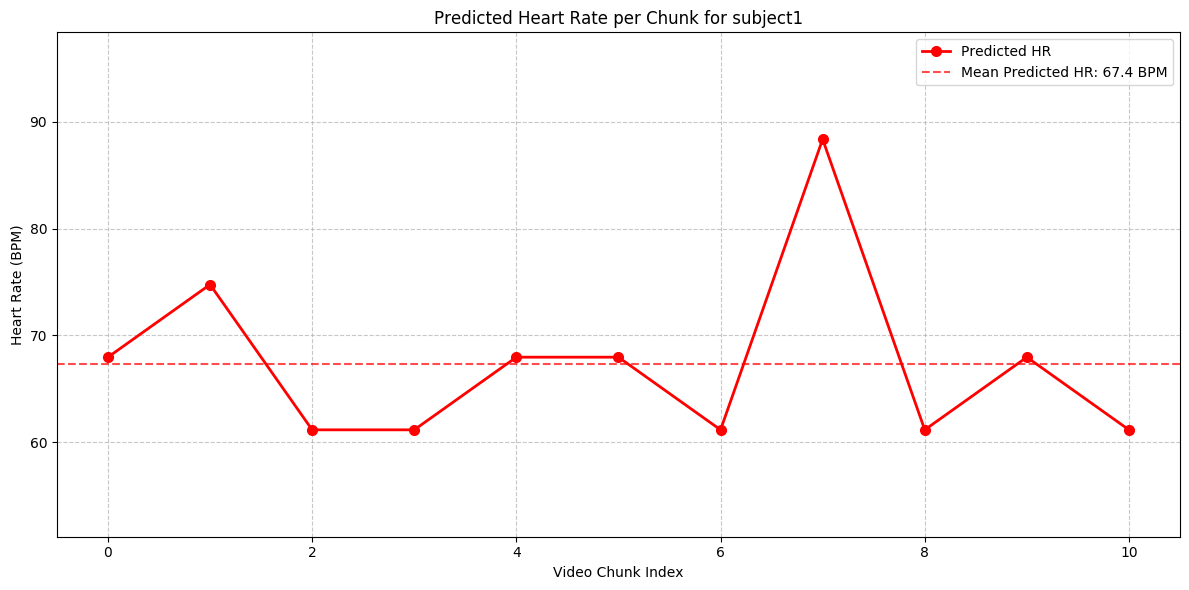

In [97]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
from scipy.signal import butter
import sys
import os

# Assuming 'data_out_path' is defined in a previous cell
# Assuming sys.path is correctly set for the imports below
# from evaluation.post_process import _detrend, _calculate_fft_hr 
# If the above import fails, it means sys.path isn't set from a previous cell,
# or the functions are not in that exact location.
# You might need to re-add:
# repo_root_path_str = '/home/maciek/GitHub/rPPG-Toolbox' # Or use find_git_root() if defined
if str(repo_root) not in sys.path:
    sys.path.append(repo_root_path_str)
from evaluation.post_process import _detrend, _calculate_fft_hr

# --- 1. Load Data ---
if 'data_out_path' not in locals() and 'data_out_path' not in globals():
    print("ERROR: 'data_out_path' is not defined. Please run the cell that defines it (e.g., cell ID 81dc2cd1).")
else:
    try:
        with open(data_out_path, 'rb') as f:
            results = pickle.load(f)

        subject_id = 'subject1' # Assuming you want to plot for subject1
        
        if subject_id not in results.get('predictions', {}):
            print(f"ERROR: Subject '{subject_id}' not found in predictions.")
        else:
            subject_preds_data = results['predictions'][subject_id]
            fs = results.get('fs', 30) # Default to 30 if not in pickle, but it should be
            label_type = results.get('label_type', 'DiffNormalized') # Default if not in pickle
            diff_flag = (label_type == 'DiffNormalized')

            print(f"Processing {subject_id}: fs={fs}, diff_flag={diff_flag}")

            # --- 2. Calculate HR per chunk for Predictions ---
            chunk_hrs_pred = []
            
            # Sort chunks by index to ensure correct order
            sorted_chunk_indices = sorted(subject_preds_data.keys())

            for chunk_idx in sorted_chunk_indices:
                pred_chunk_tensor = subject_preds_data[chunk_idx]
                
                # Convert tensor to numpy array and flatten
                if hasattr(pred_chunk_tensor, 'cpu'): # PyTorch tensor
                    pred_chunk_np = pred_chunk_tensor.cpu().numpy().flatten()
                elif hasattr(pred_chunk_tensor, 'numpy'): # Other tensor types
                    pred_chunk_np = pred_chunk_tensor.numpy().flatten()
                else: # Assuming it's already numpy-like or list
                    pred_chunk_np = np.array(pred_chunk_tensor).flatten()

                # Process signal
                processed_signal = pred_chunk_np
                if diff_flag:
                    processed_signal = np.cumsum(processed_signal)
                
                processed_signal = _detrend(processed_signal, 100)
                
                # Apply bandpass filter (consistent with metrics calculation)
                # 0.75 Hz to 2.5 Hz (equals 45 to 150 BPM)
                low_cutoff_hz = 0.75
                high_cutoff_hz = 2.5
                [b_bp, a_bp] = butter(1, [low_cutoff_hz / (fs / 2), high_cutoff_hz / (fs / 2)], btype='bandpass')
                processed_signal_filtered = scipy.signal.filtfilt(b_bp, a_bp, np.double(processed_signal))
                
                # Calculate HR using FFT
                hr_p = _calculate_fft_hr(processed_signal_filtered, fs=fs)
                chunk_hrs_pred.append(hr_p)

            # --- 3. Plot HR over Time (Chunks) ---
            if not chunk_hrs_pred:
                print("No heart rates calculated to plot.")
            else:
                fig, ax1 = plt.subplots(figsize=(12, 6))
                chunk_numbers = range(len(chunk_hrs_pred))

                ax1.plot(chunk_numbers, chunk_hrs_pred, 'o-', color='red', linewidth=2, markersize=7, label='Predicted HR')
                
                mean_hr_pred = np.mean(chunk_hrs_pred)
                ax1.axhline(y=mean_hr_pred, color='red', linestyle='--', alpha=0.7, label=f'Mean Predicted HR: {mean_hr_pred:.1f} BPM')

                ax1.set_xlabel('Video Chunk Index')
                ax1.set_ylabel('Heart Rate (BPM)')
                ax1.set_title(f'Predicted Heart Rate per Chunk for {subject_id}')
                ax1.legend()
                ax1.grid(True, linestyle='--', alpha=0.7)
                
                # Adjust y-axis limits for better visualization
                min_hr_val = min(chunk_hrs_pred) if chunk_hrs_pred else 40
                max_hr_val = max(chunk_hrs_pred) if chunk_hrs_pred else 120
                ax1.set_ylim(max(0, min_hr_val - 10), max_hr_val + 10)
                
                plt.tight_layout()
                plt.show()

    except FileNotFoundError:
        print(f"ERROR: Pickle file not found at {data_out_path}. Please ensure the path is correct and the file exists.")
    except ImportError as e:
        print(f"ERROR: Could not import necessary functions: {e}")
        print("Please ensure rPPG-Toolbox is in sys.path and evaluation.post_process has _detrend and _calculate_fft_hr.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")


Processing 'subject1': 11 chunks.
Sampling Frequency (fs): 29 Hz
Label Type: DiffNormalized, Diff Flag: True


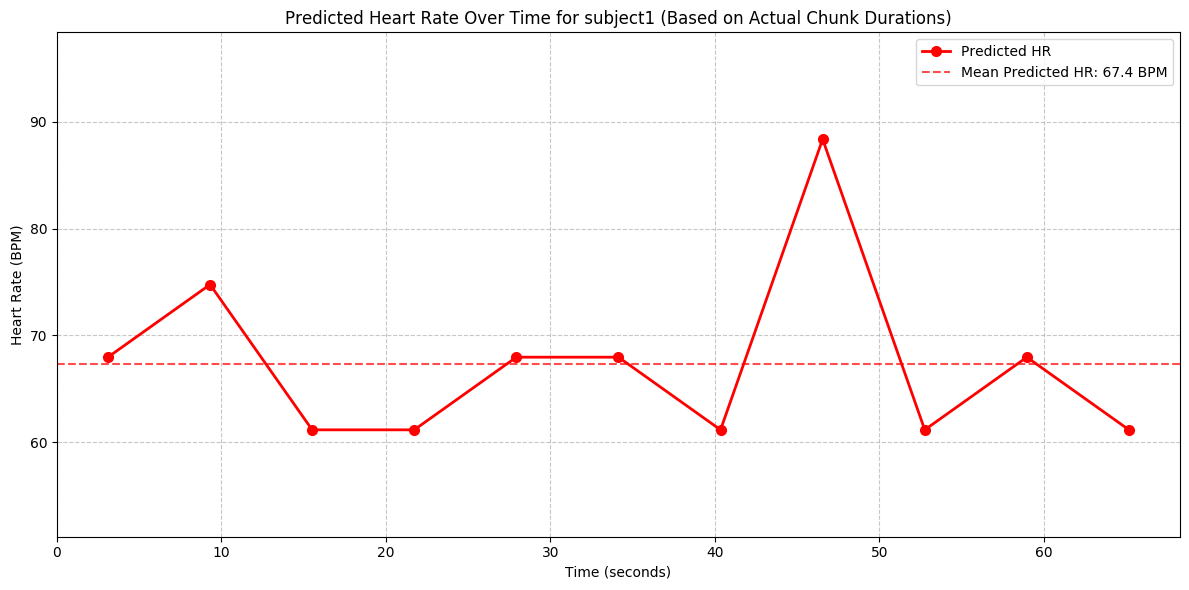

In [99]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
from scipy.signal import butter
import sys
import os

# Ensure the rPPG-Toolbox path is available for imports
# (Should be handled by an earlier cell)
# repo_root_path_str = '/home/maciek/GitHub/rPPG-Toolbox' 
if str(repo_root) not in sys.path:
    sys.path.append(repo_root_path_str)

from evaluation.post_process import _detrend, _calculate_fft_hr

if 'data_out_path' not in locals() and 'data_out_path' not in globals():
    print("ERROR: 'data_out_path' is not defined. Please ensure Cell 5 (ID: 81dc2cd1) has been executed.")
else:
    try:
        with open(data_out_path, 'rb') as f:
            results = pickle.load(f)

        subject_id = 'subject1' 
        
        if 'predictions' not in results:
            raise KeyError("'predictions' key not found in the pickle file.")
        if subject_id not in results['predictions']:
            raise KeyError(f"Subject '{subject_id}' not found in 'predictions'. Available: {list(results['predictions'].keys())}")
        if 'fs' not in results:
            raise KeyError("'fs' (sampling frequency) not found in the pickle file.")
        
        subject_preds_chunks_dict = results['predictions'][subject_id]
        fs = results['fs'] 
        label_type = results.get('label_type', 'DiffNormalized')
        diff_flag = (label_type == 'DiffNormalized')
            
        num_chunks = len(subject_preds_chunks_dict)
        print(f"Processing '{subject_id}': {num_chunks} chunks.")
        print(f"Sampling Frequency (fs): {fs} Hz")
        print(f"Label Type: {label_type}, Diff Flag: {diff_flag}")

        chunk_hrs_pred = []
        chunk_time_midpoints = []
        cumulative_time_at_chunk_start = 0.0 # Tracks the start time of the current chunk
            
        sorted_chunk_indices = sorted(subject_preds_chunks_dict.keys())

        for chunk_idx in sorted_chunk_indices:
            pred_chunk_tensor = subject_preds_chunks_dict[chunk_idx]
            
            if hasattr(pred_chunk_tensor, 'cpu'):
                pred_chunk_np = pred_chunk_tensor.cpu().numpy().flatten()
            elif hasattr(pred_chunk_tensor, 'numpy'):
                pred_chunk_np = pred_chunk_tensor.numpy().flatten()
            else:
                pred_chunk_np = np.array(pred_chunk_tensor).flatten()

            actual_chunk_len_frames = len(pred_chunk_np)
            actual_chunk_duration_seconds = actual_chunk_len_frames / fs
            # print(f"  Chunk {chunk_idx}: Actual length = {actual_chunk_len_frames} frames, Duration = {actual_chunk_duration_seconds:.2f}s.")


            processed_signal = pred_chunk_np
            if diff_flag:
                processed_signal = np.cumsum(processed_signal)
            
            if len(processed_signal) < 3: 
                print(f"  Skipping chunk {chunk_idx} due to insufficient length ({len(processed_signal)} samples) for detrend.")
                chunk_hrs_pred.append(np.nan) 
                # Plot this NaN at the midpoint of this chunk's actual duration
                chunk_time_midpoints.append(cumulative_time_at_chunk_start + actual_chunk_duration_seconds / 2.0)
                cumulative_time_at_chunk_start += actual_chunk_duration_seconds # Advance by actual duration
                continue

            processed_signal = _detrend(processed_signal, 100)
            
            low_cutoff_hz = 0.75 
            high_cutoff_hz = 2.5 
            if len(processed_signal) <= 6: 
                print(f"  Skipping chunk {chunk_idx} due to insufficient length ({len(processed_signal)} samples) for filtering.")
                chunk_hrs_pred.append(np.nan)
                chunk_time_midpoints.append(cumulative_time_at_chunk_start + actual_chunk_duration_seconds / 2.0)
                cumulative_time_at_chunk_start += actual_chunk_duration_seconds
                continue

            [b_bp, a_bp] = butter(1, [low_cutoff_hz / (fs / 2), high_cutoff_hz / (fs / 2)], btype='bandpass')
            processed_signal_filtered = scipy.signal.filtfilt(b_bp, a_bp, np.double(processed_signal))
            
            hr_p = _calculate_fft_hr(processed_signal_filtered, fs=fs)
            chunk_hrs_pred.append(hr_p)
            
            chunk_time_midpoints.append(cumulative_time_at_chunk_start + actual_chunk_duration_seconds / 2.0)
            cumulative_time_at_chunk_start += actual_chunk_duration_seconds

        # --- 3. Plot HR over Time ---
        if not chunk_hrs_pred:
            print("No heart rates calculated to plot.")
        else:
            fig, ax1 = plt.subplots(figsize=(12, 6))
            plot_times = [t for t, hr in zip(chunk_time_midpoints, chunk_hrs_pred) if not np.isnan(hr)]
            plot_hrs = [hr for hr in chunk_hrs_pred if not np.isnan(hr)]

            if not plot_hrs:
                 print("All chunks were skipped or resulted in NaN HR. Cannot plot.")
            else:
                ax1.plot(plot_times, plot_hrs, 'o-', color='red', linewidth=2, markersize=7, label='Predicted HR')
                
                mean_hr_pred = np.nanmean(chunk_hrs_pred)
                ax1.axhline(y=mean_hr_pred, color='red', linestyle='--', alpha=0.7, label=f'Mean Predicted HR: {mean_hr_pred:.1f} BPM')

                ax1.set_xlabel('Time (seconds)')
                ax1.set_ylabel('Heart Rate (BPM)')
                ax1.set_title(f'Predicted Heart Rate Over Time for {subject_id} (Based on Actual Chunk Durations)')
                ax1.legend()
                ax1.grid(True, linestyle='--', alpha=0.7)
                
                min_hr_val = np.nanmin(chunk_hrs_pred) if plot_hrs else 40
                max_hr_val = np.nanmax(chunk_hrs_pred) if plot_hrs else 120
                ax1.set_ylim(max(0, min_hr_val - 10), max_hr_val + 10)
                
                plt.tight_layout()
                plt.show()

    except FileNotFoundError:
        print(f"ERROR: Pickle file not found at {data_out_path}.")
    except ImportError as e:
        print(f"ERROR: Could not import functions: {e}")
    except KeyError as e:
        print(f"ERROR: Key not found: {e}. Check pickle structure.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")


Processing 'subject1': 11 chunks.
Sampling Frequency (fs): 29 Hz
Label Type: DiffNormalized, Diff Flag: True


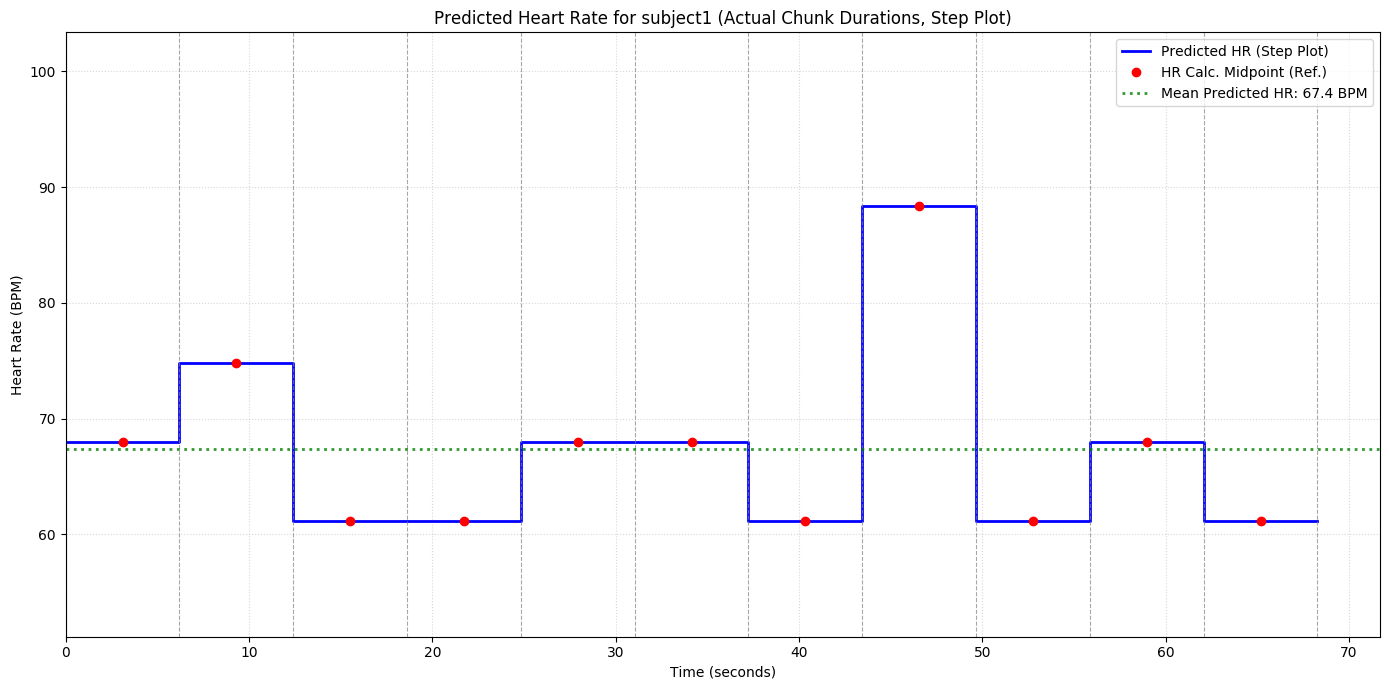

In [100]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
from scipy.signal import butter
import sys
import os

# Ensure the rPPG-Toolbox path is available for imports
# (Should be handled by an earlier cell)
# repo_root_path_str = '/home/maciek/GitHub/rPPG-Toolbox' 

if str(repo_root) not in sys.path:
    sys.path.append(repo_root_path_str)

from evaluation.post_process import _detrend, _calculate_fft_hr

if 'data_out_path' not in locals() and 'data_out_path' not in globals():
    print("ERROR: 'data_out_path' is not defined. Please ensure Cell 5 (ID: 81dc2cd1) has been executed.")
else:
    try:
        with open(data_out_path, 'rb') as f:
            results = pickle.load(f)

        subject_id = 'subject1' 
        
        if 'predictions' not in results:
            raise KeyError("'predictions' key not found in the pickle file.")
        if subject_id not in results['predictions']:
            raise KeyError(f"Subject '{subject_id}' not found in 'predictions'. Available: {list(results['predictions'].keys())}")
        if 'fs' not in results:
            raise KeyError("'fs' (sampling frequency) not found in the pickle file.")
        
        subject_preds_chunks_dict = results['predictions'][subject_id]
        fs = results['fs'] 
        label_type = results.get('label_type', 'DiffNormalized')
        diff_flag = (label_type == 'DiffNormalized')
            
        num_chunks = len(subject_preds_chunks_dict)
        print(f"Processing '{subject_id}': {num_chunks} chunks.")
        print(f"Sampling Frequency (fs): {fs} Hz")
        print(f"Label Type: {label_type}, Diff Flag: {diff_flag}")

        chunk_hrs_pred = []
        chunk_start_times = [0.0] # Initialize with start time of the first chunk
        chunk_end_times = []
        cumulative_time = 0.0
            
        sorted_chunk_indices = sorted(subject_preds_chunks_dict.keys())

        for chunk_idx in sorted_chunk_indices:
            pred_chunk_tensor = subject_preds_chunks_dict[chunk_idx]
            
            if hasattr(pred_chunk_tensor, 'cpu'):
                pred_chunk_np = pred_chunk_tensor.cpu().numpy().flatten()
            elif hasattr(pred_chunk_tensor, 'numpy'):
                pred_chunk_np = pred_chunk_tensor.numpy().flatten()
            else:
                pred_chunk_np = np.array(pred_chunk_tensor).flatten()

            actual_chunk_len_frames = len(pred_chunk_np)
            actual_chunk_duration_seconds = actual_chunk_len_frames / fs
            
            # Update times
            if chunk_idx > sorted_chunk_indices[0]: # For chunks after the first
                 chunk_start_times.append(cumulative_time)
            cumulative_time += actual_chunk_duration_seconds
            chunk_end_times.append(cumulative_time)

            processed_signal = pred_chunk_np
            if diff_flag:
                processed_signal = np.cumsum(processed_signal)
            
            hr_p_current_chunk = np.nan # Default to NaN if skipped
            if len(processed_signal) < 3: 
                print(f"  Skipping chunk {chunk_idx} due to insufficient length ({len(processed_signal)} samples) for detrend.")
            elif len(processed_signal) <= 6: # Based on butterworth order 1 padlen
                print(f"  Skipping chunk {chunk_idx} due to insufficient length ({len(processed_signal)} samples) for filtering.")
            else:
                processed_signal_detrended = _detrend(processed_signal, 100)
                low_cutoff_hz = 0.75 
                high_cutoff_hz = 2.5 
                [b_bp, a_bp] = butter(1, [low_cutoff_hz / (fs / 2), high_cutoff_hz / (fs / 2)], btype='bandpass')
                processed_signal_filtered = scipy.signal.filtfilt(b_bp, a_bp, np.double(processed_signal_detrended))
                hr_p_current_chunk = _calculate_fft_hr(processed_signal_filtered, fs=fs)
            
            chunk_hrs_pred.append(hr_p_current_chunk)

        # --- 3. Plot HR over Time (Step Plot with Chunk Boundaries) ---
        if not chunk_hrs_pred:
            print("No heart rates calculated to plot.")
        else:
            fig, ax1 = plt.subplots(figsize=(14, 7)) # Increased figure size for clarity

            # Prepare data for step plot: need x-coordinates for edges of steps
            # x_step will have points at start and end of each chunk
            # y_step will have HR repeated for start and end of its chunk
            x_step = []
            y_step = []
            for i in range(len(chunk_hrs_pred)):
                if not np.isnan(chunk_hrs_pred[i]): # Only plot non-NaN HRs
                    x_step.extend([chunk_start_times[i], chunk_end_times[i]])
                    y_step.extend([chunk_hrs_pred[i], chunk_hrs_pred[i]])
            
            if not y_step:
                print("All calculated HRs are NaN. Cannot plot.")
            else:
                ax1.plot(x_step, y_step, color='blue', linewidth=2, label='Predicted HR (Step Plot)')

                # Overlay circles at the midpoint of each chunk to show the calculated value's timing
                # More visually, the step plot itself shows the HR for the chunk duration
                # For clarity, we can plot original points if desired or just rely on the step plot
                # Example: Plotting points at midpoints for reference
                mid_points_x = [(s + e) / 2 for s, e, hr in zip(chunk_start_times, chunk_end_times, chunk_hrs_pred) if not np.isnan(hr)]
                mid_points_y = [hr for hr in chunk_hrs_pred if not np.isnan(hr)]
                ax1.plot(mid_points_x, mid_points_y, 'o', color='red', markersize=6, label='HR Calc. Midpoint (Ref.)')


                # Add vertical lines for chunk boundaries
                for t_start, t_end in zip(chunk_start_times, chunk_end_times):
                    ax1.axvline(x=t_start, color='gray', linestyle='--', linewidth=0.8, alpha=0.7)
                # Add the final boundary
                if chunk_end_times:
                     ax1.axvline(x=chunk_end_times[-1], color='gray', linestyle='--', linewidth=0.8, alpha=0.7)


                mean_hr_pred = np.nanmean(chunk_hrs_pred)
                ax1.axhline(y=mean_hr_pred, color='green', linestyle=':', linewidth=2, alpha=0.8, label=f'Mean Predicted HR: {mean_hr_pred:.1f} BPM')

                ax1.set_xlabel('Time (seconds)')
                ax1.set_ylabel('Heart Rate (BPM)')
                ax1.set_title(f'Predicted Heart Rate for {subject_id} (Actual Chunk Durations, Step Plot)')
                ax1.legend(loc='upper right')
                ax1.grid(True, linestyle=':', alpha=0.5)
                
                min_hr_val = np.nanmin(chunk_hrs_pred) if y_step else 40
                max_hr_val = np.nanmax(chunk_hrs_pred) if y_step else 120
                ax1.set_ylim(max(0, min_hr_val - 10), max_hr_val + 15) # Adjusted y-limit for legend
                if chunk_end_times:
                    ax1.set_xlim(0, chunk_end_times[-1] + chunk_end_times[-1]*0.05) # Add a bit of padding to x-axis

                plt.tight_layout()
                plt.show()

    except FileNotFoundError:
        print(f"ERROR: Pickle file not found at {data_out_path}.")
    except ImportError as e:
        print(f"ERROR: Could not import functions: {e}")
    except KeyError as e:
        print(f"ERROR: Key not found: {e}. Check pickle structure.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")


Processing 'subject1': 11 chunks. fs=29 Hz. diff_flag=True


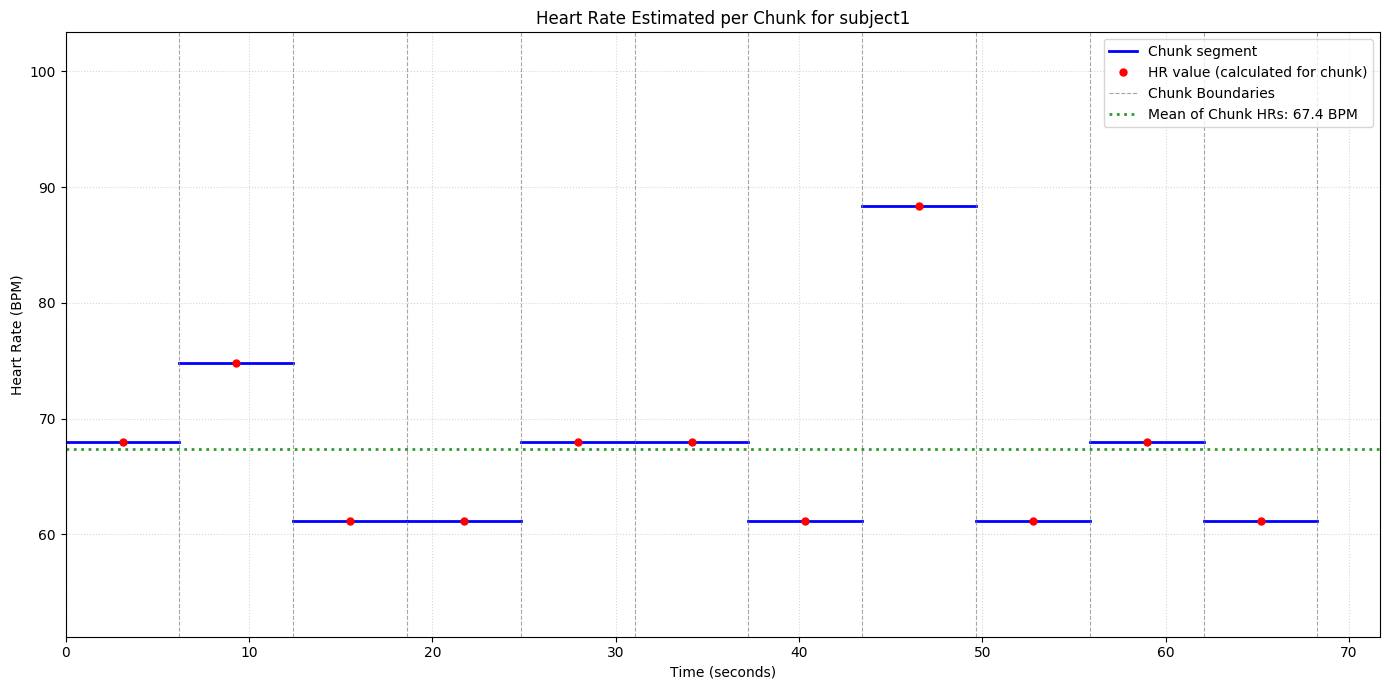

In [105]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
from scipy.signal import butter
import sys
import os

# Assuming rPPG-Toolbox path is available
from evaluation.post_process import _detrend, _calculate_fft_hr

if 'data_out_path' not in locals() and 'data_out_path' not in globals():
    print("ERROR: 'data_out_path' is not defined.")
else:
    try:
        with open(data_out_path, 'rb') as f:
            results = pickle.load(f)

        subject_id = 'subject1'
        
        if 'predictions' not in results or subject_id not in results['predictions'] or 'fs' not in results:
            raise KeyError("Pickle file missing essential keys like 'predictions', 'subject1', or 'fs'.")
        
        subject_preds_chunks_dict = results['predictions'][subject_id]
        fs = results['fs']
        label_type = results.get('label_type', 'DiffNormalized')
        diff_flag = (label_type == 'DiffNormalized')
            
        num_chunks = len(subject_preds_chunks_dict)
        print(f"Processing '{subject_id}': {num_chunks} chunks. fs={fs} Hz. diff_flag={diff_flag}")

        chunk_hrs_pred = []
        chunk_start_times = [] 
        cumulative_time = 0.0
            
        sorted_chunk_indices = sorted(subject_preds_chunks_dict.keys())

        for chunk_idx in sorted_chunk_indices:
            pred_chunk_tensor = subject_preds_chunks_dict[chunk_idx]
            
            if hasattr(pred_chunk_tensor, 'cpu'):
                pred_chunk_np = pred_chunk_tensor.cpu().numpy().flatten()
            elif hasattr(pred_chunk_tensor, 'numpy'):
                pred_chunk_np = pred_chunk_tensor.numpy().flatten()
            else:
                pred_chunk_np = np.array(pred_chunk_tensor).flatten()

            actual_chunk_len_frames = len(pred_chunk_np)
            actual_chunk_duration_seconds = actual_chunk_len_frames / fs
            
            chunk_start_times.append(cumulative_time) # Start time of the current chunk

            processed_signal = pred_chunk_np
            if diff_flag:
                processed_signal = np.cumsum(processed_signal)
            
            hr_p_current_chunk = np.nan
            if len(processed_signal) < 3 or len(processed_signal) <= 6 : # Check for detrend and filter
                status = "short for detrend" if len(processed_signal) < 3 else "short for filter"
                print(f"  Skipping chunk {chunk_idx} due to insufficient length ({len(processed_signal)} samples) - {status}.")
            else:
                processed_signal_detrended = _detrend(processed_signal, 100)
                low_cutoff_hz, high_cutoff_hz = 0.75, 2.5
                [b_bp, a_bp] = butter(1, [low_cutoff_hz / (fs / 2), high_cutoff_hz / (fs / 2)], btype='bandpass')
                processed_signal_filtered = scipy.signal.filtfilt(b_bp, a_bp, np.double(processed_signal_detrended))
                hr_p_current_chunk = _calculate_fft_hr(processed_signal_filtered, fs=fs)
            
            chunk_hrs_pred.append(hr_p_current_chunk)
            cumulative_time += actual_chunk_duration_seconds # Update for the next chunk's start time
        
        # Add the final cumulative time to define the end of the last step segment for plotting
        chunk_end_of_last_segment = cumulative_time 
            

        # --- 3. Plot HR over Time (using idiomatic plt.step) ---
        if not chunk_hrs_pred:
            print("No heart rates calculated to plot.")
        else:
            fig, ax1 = plt.subplots(figsize=(14, 7))

            # Prepare data for plt.step:
            # x_coords are the left edges of the steps (all chunk_start_times)
            # y_coords are the HR values for those chunks.
            # We need to handle NaNs carefully for plt.step if we want continuous lines where possible,
            # or plot segments individually. Plotting segments is robust to NaNs.

            valid_segments_count = 0
            for i in range(len(chunk_hrs_pred)):
                if not np.isnan(chunk_hrs_pred[i]):
                    # For each valid HR, draw a step segment from its start_time to its end_time
                    # The end_time for chunk i is the start_time for chunk i+1, or end_of_last_segment
                    current_chunk_start_time = chunk_start_times[i]
                    next_chunk_start_time = chunk_start_times[i+1] if (i + 1) < len(chunk_start_times) else chunk_end_of_last_segment
                    
                    # Use plt.plot to draw a horizontal line for the segment
                    # This gives explicit control and avoids plt.step's own vertical lines
                    ax1.plot([current_chunk_start_time, next_chunk_start_time], 
                             [chunk_hrs_pred[i], chunk_hrs_pred[i]], 
                             color='blue', linewidth=2,
                             label='Chunk segment' if valid_segments_count == 0 else None)
                    valid_segments_count += 1
            
            if valid_segments_count == 0:
                 print("All calculated HRs are NaN. Cannot plot meaningful step plot.")
            else:
                # Plot red circles at the midpoints (optional, for reference to calculation point)
                mid_points_x = []
                mid_points_y = []
                temp_cumulative_time_for_midpoints = 0.0
                for i in range(len(chunk_hrs_pred)): # Iterate through all original chunks for midpoints
                    original_chunk_data = subject_preds_chunks_dict[sorted_chunk_indices[i]]
                    if hasattr(original_chunk_data, 'cpu'): pred_chunk_np_for_len = original_chunk_data.cpu().numpy().flatten()
                    elif hasattr(original_chunk_data, 'numpy'): pred_chunk_np_for_len = original_chunk_data.numpy().flatten()
                    else: pred_chunk_np_for_len = np.array(original_chunk_data).flatten()
                    
                    actual_chunk_duration_seconds = len(pred_chunk_np_for_len) / fs
                    
                    if not np.isnan(chunk_hrs_pred[i]):
                        mid_points_x.append(temp_cumulative_time_for_midpoints + actual_chunk_duration_seconds / 2.0)
                        mid_points_y.append(chunk_hrs_pred[i])
                    temp_cumulative_time_for_midpoints += actual_chunk_duration_seconds
                
                if mid_points_x:
                    ax1.plot(mid_points_x, mid_points_y, 'o', color='red', markersize=5, 
                             label='HR value (calculated for chunk)')

                # Add vertical lines for actual chunk boundaries (start of each chunk)
                # These lines now explicitly show the window for which the HR is constant
                for t_start_boundary in chunk_start_times:
                    ax1.axvline(x=t_start_boundary, color='gray', linestyle='--', linewidth=0.8, alpha=0.7)
                # Add boundary for the end of the last chunk
                if chunk_start_times: # Check if list is not empty
                     ax1.axvline(x=chunk_end_of_last_segment, color='gray', linestyle='--', linewidth=0.8, alpha=0.7, label='Chunk Boundaries')


                mean_hr_pred = np.nanmean(chunk_hrs_pred)
                ax1.axhline(y=mean_hr_pred, color='green', linestyle=':', linewidth=2, alpha=0.8, 
                            label=f'Mean of Chunk HRs: {mean_hr_pred:.1f} BPM')

                ax1.set_xlabel('Time (seconds)')
                ax1.set_ylabel('Heart Rate (BPM)')
                ax1.set_title(f'Heart Rate Estimated per Chunk for {subject_id}')
                ax1.legend(loc='upper right')
                ax1.grid(True, linestyle=':', alpha=0.5)
                
                non_nan_hrs = [hr for hr in chunk_hrs_pred if not np.isnan(hr)]
                if non_nan_hrs:
                    min_hr_val = min(non_nan_hrs)
                    max_hr_val = max(non_nan_hrs)
                    ax1.set_ylim(max(0, min_hr_val - 10), max_hr_val + 15) 
                
                if chunk_start_times: # Ensure there's data to set xlim
                    ax1.set_xlim(0, chunk_end_of_last_segment + chunk_end_of_last_segment*0.05 if chunk_end_of_last_segment > 0 else 10)


            plt.tight_layout()
            plt.show()

    # ... [rest of the error handling code] ...

    except FileNotFoundError:
        print(f"ERROR: Pickle file not found at {data_out_path}.")
    except ImportError as e:
        print(f"ERROR: Could not import functions: {e}")
    except KeyError as e:
        print(f"ERROR: Key not found: {e}. Check pickle structure.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")